# Summer project 

Note that you should have CAMB installed, which can be done by running `pip install camb`. For more information, visit https://camb.info/.

The theory is heavily inspired in the articles contained on the folder ''Papers/''

In [91]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from astropy import constants as const
import scipy.integrate as integrate
import scipy.interpolate as interpolate

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders. Delete these two lines for pip/conda install.
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

# matplotlib config
plt.rc('font', size=15)  #fontsize for plots
#plt.rc('axes', titlesize=20)#fontsize of the title

Using CAMB 1.3.6 installed at /home/vpedre/anaconda3/lib/python3.9/site-packages/camb


In [92]:
l_speed = const.c.value / 1000

In [93]:
dict_fiducial = {'Omegam': 0.32, 'Omegab': 0.05, 'Omegade': 0.68, 'Omegac': 0.2685628338348412,
                 'w0': -1.0, 'wa': 0, 'hubble': 0.67, 'ns': 0.96, 'sigma8': 0.815584, 'gamma': 0.55}

locals().update(dict_fiducial)

## Background Quantities

In the context of GR, cosmic acceleration requires a fluid, dubbed **Dark Energy** (DE), with an equation of state $w_{DE} < -1/3$. The standard model of csomology, commonly refered to as the $\Lambda CDM$ model, assumes that this phenomenon is due to the presence of a cosmological constant $\Lambda$ described by a constant equation state $w_{\Lambda} = -1$, which corresponds to a time-independent energy density. This has some problems (*cosmological constant problem* and *coincidence problem*), so a more general scenario for the component responsible for cosmic acceleration postulates a dynamical DE, with a dependent equation of state parameter $w_{DE}(z)$.
$$w_{DE}(z) = w_0 + w_a\frac{z}{1+z}$$
Where $w_0$ is  the present value of the equation of state and $w_a$ is a measure of its variation. The evolution of the DE density obeys
$$\rho_{DE} (z) = \rho_{DE,0} (1+z)^{3(1+w_0+w_a)}exp\left[-3w_a\frac{z}{1+z}\right] $$

Then, we can get
$$E(z) = \sqrt{
    \Omega_{m,0}(1+z)^3 + \Omega_{DE,0}(1+z)^{3(1+w_0+w_a)}exp\left[-3w_a\frac{z}{1+z}\right] + \Omega_{K,0}(1+z)^2
}$$
With the current DE density $\Omega_{DE,0}$ satisfying the relation $\Omega_{DE,0} = 1 - \Omega_{m,0} - \Omega_{K, 0}$. The $\Lambda CDM$ model can be recovered by setting $w_0=-1$ and $w_a=0$, in which case

$$E(z) = \sqrt{
    \Omega_{m,0}(1+z)^3 + \Omega_{\Lambda,0} + \Omega_{K,0}(1+z)^2
}$$

In [94]:
def E(z, cosparam=dict_fiducial):
    locals().update(cosparam)
    mat = Omegam * (1 + z) ** 3
    de = Omegade *(1 + z) ** (3 * (1 + w0 + wa)) * \
        np.exp(-3 * wa * z / (1 + z))
    cur = (1 - Omegam - Omegade) * (1 + z) ** 2
    return np.sqrt(mat + de + cur)

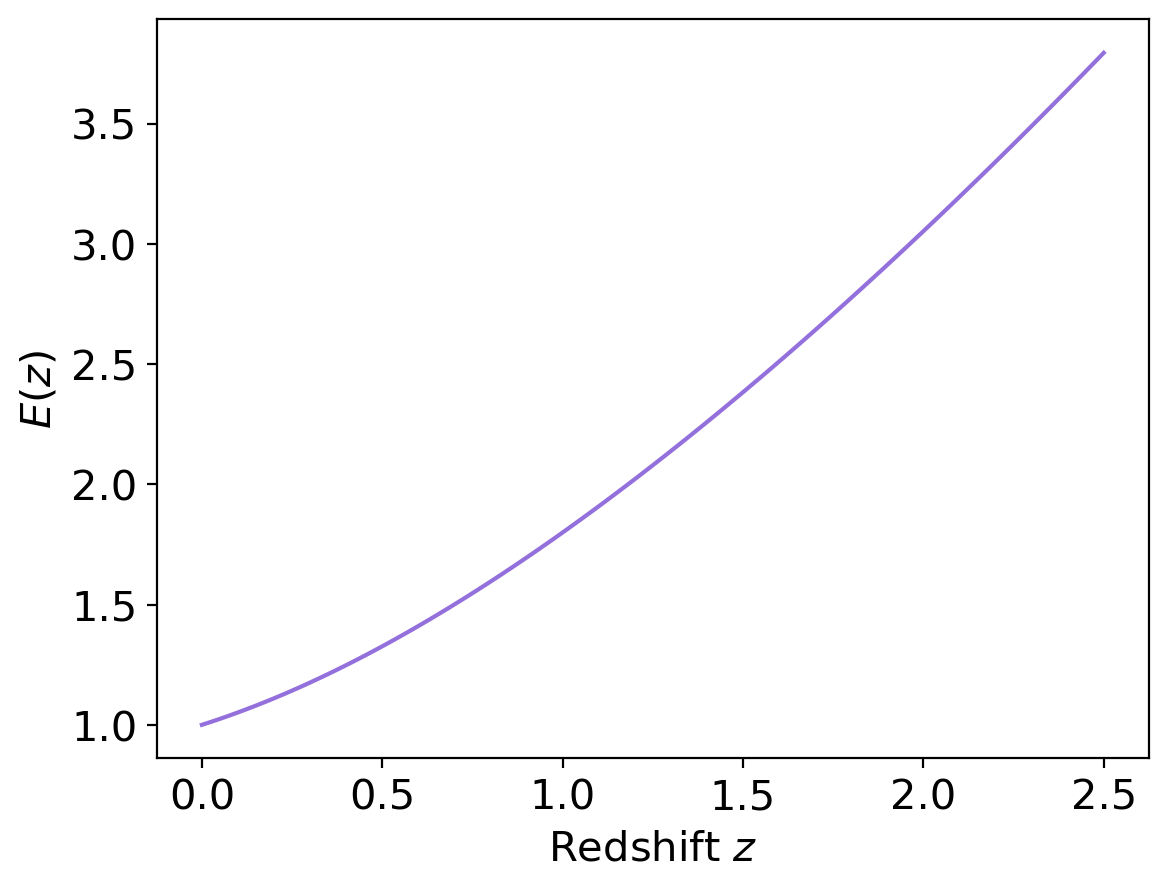

In [95]:
z_to_plot = np.linspace(0, 2.5, 100)

fig, ax = plt.subplots()

ax.plot(z_to_plot, E(z_to_plot), c='mediumpurple')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$E(z)$');
# ax.set_title('');

## Distance measurements

The comoving distance to an object at redshift $z$ can be computed as
$$r(z)  \frac{c}{H_0} \int _0^z \frac{dz}{E(z)}$$
This quantity is not a direct observable, but it is closely related to other distance definitions that are directly linked with cosmological observations. A relevant distance is the **angular diameter disantance** (at least for our forecasts), whose definitiion is based on the relation between the apparent angular size of an object and its true physical size in Euclidean space, which is relate to the comoving distance by
$$D_A(z) = \begin{cases}
(1 + z)^{-1} \frac{c}{H_0} \frac{1}{\sqrt{|\Omega_{K,0}|}} sin\left[\sqrt{|\Omega_{K,0}|} \frac{H_0}{c}r(z)\right]& \text{if}\, \, \Omega_{K,0} < 0 \\
(1 + z)^{-1} r(z) & \text{if}\, \, \Omega_{K,0} = 0 \\
(1 + z)^{-1} \frac{c}{H_0} \frac{1}{\sqrt{\Omega_{K,0}}} sinh\left[\sqrt{\Omega_{K,0}} \frac{H_0}{c}r(z)\right]& \text{if}\, \, \Omega_{K,0} < 0 \\
\end{cases}$$

and this angular diameter distance is related to the transverse comoving distance by $D_A = D_M / (1+z)$

In [96]:
def r(z, cosparam=dict_fiducial):
    """Comoving Distance as a function of the redshift
    trapz from numpy is used.
    ===================================================
    Input: redshift z
    Output: comoving distance r
    """
    def integrand(u):
        return 1/E(u, cosparam)
    if type(z) == np.ndarray:
        integral = np.zeros(len(z))
        for idx, redshift in enumerate(z):
            z_int = np.linspace(0, redshift, len(z))
            integral[idx] = np.trapz(integrand(z_int), z_int)
    else: 
        z_int = np.linspace(0, z, 200)
        integral = np.trapz(integrand(z_int), z_int)
    return integral * l_speed / (cosparam['hubble'] * 100)


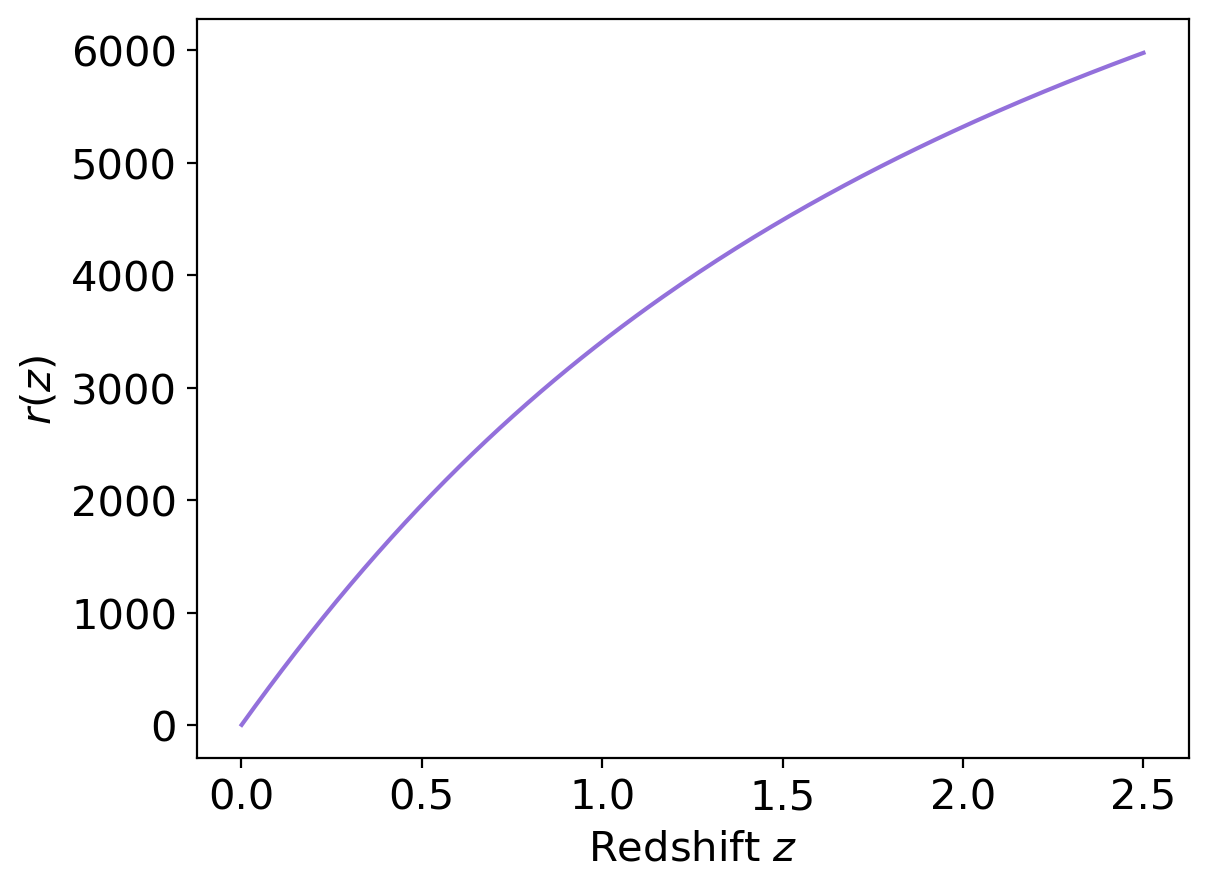

In [97]:
z_to_plot = np.linspace(0.001, 2.5, 200)

fig, ax = plt.subplots()
ax.plot(z_to_plot, r(z_to_plot), c='mediumpurple')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$r(z)$');
# ax.set_title('');

In [98]:
def D_A(z, cosparam=dict_fiducial):
    """Angular diameter distance as a function of the redshift.
    Note that there are different definitions for different
    space-time curvatures.
    ===================================================
    Inputs: redshift z; curvature density Omk, default given by camb (optional)
    Outputs: angular diameter distance D_A
    """
    Omk = 1 - cosparam['Omegam'] - cosparam['Omegade']
    H0 = cosparam['hubble'] * 100
    if Omk == 0:
        return r(z) / (1 + z)
    
    arg = np.sqrt(np.abs(Omk)) * H0 / l_speed * r(z)
    prop_const = l_speed / H0 / np.sqrt(np.abs(Omk))
    
    if Omk < 0:
        return prop_const / (1 + z) * np.sin(arg)

    else:
        return prop_const / (1 + z) * np.sinh(arg)


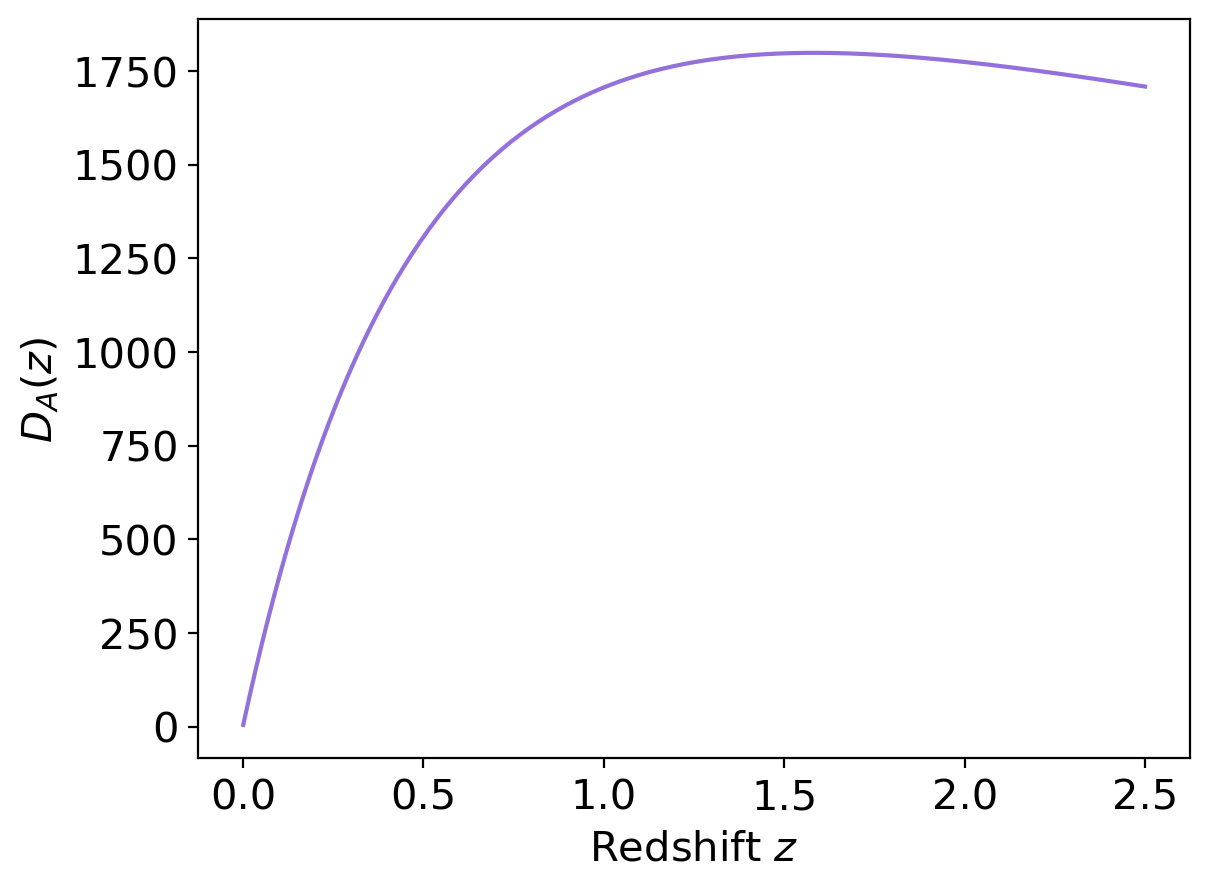

In [99]:
z_to_plot = np.linspace(0.001, 2.5, 200)

fig, ax = plt.subplots()

ax.plot(z_to_plot, D_A(z_to_plot), c='mediumpurple')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$D_A(z)$');
# ax.set_title('');

## Weak lensing observable

We refer to *weak lensing* as the physical phenomenom and *cosmic shear* as the observable summary statistic that uses weak lensing to extract cosmological parameters.

The large-sacale cosmic structure deflects the path of photons from distant galaxies, which induces distortions in the images of these galaxies. *Convergence* is a change in the observed size of a galaxy and *shear* is a change in the observed third flattening or third eccentricity (known as ellipticity or polarisation). The shear field caused by large-scale structure has zero mean because we assume isotropy and homogeneity of the Universe, but tis two-point correlation function and its power spectrum contain cosmological information that probes both the background evolution of the Universe and the growth of cosmic structure. This two point statistics are known as 'cosmic shear'.

In order to exploit the cosmic shear for cosmological parameter inference, the real/configuration space measurementof the two-point statistic, as a function of angular separation on the celestial sphere, is known as the *cosmic shear correlation function*. While the angular speherical-harmonic measurement of the two-point statistic is kown as the *cosmic shear power spectrum*. Both these statistics can be computed in a series of redshift bins, which is known as *tomography* and is required in order to achieve high-precision dark energy measurements. We will be focused on the latter statistic.

We consider five main quatities that must be modeled in order to recover the observable cosmic shear power spectrum.

1. **The cosmic shear power spectrum**. Is the change in the ellipticity of the image of a background galaxy, caused by the lensing effect of large-scale structure along the los. For an individual galaxy we express this, to linear order, as $$\epsilon = \gamma + \epsilon^I$$ where $\gamma$ is the cosmological shear and $\epsilon^I$ is the intrinsic ellipticity. This ellipticity is a spin-2 quantity with zero mean over a large survey area and a a non-zero two-point correlation function or power spectrum, encoding information on the expansion history of the Universe and the matter power spectrum. The spherical harmonic transform of the two-point correlation function is the angular power spectrum. Since the full computation of the csomic shear power spectrum is laborious, the Limber approximation is adopted, which allows us to write the observable as $$C_{ij}^{\gamma\gamma}(\ell)\simeq \frac{c}{H_0}\int dz\frac{W_i^\gamma(z)W_j^\gamma(z)}{E(z)r²(z)}P_{\delta\delta}\left[\frac{\ell + 1/2}{r(z)},z\right]$$ where $i$ and $j$ identify pairs of redshift bins, $E(z)$ was defined previously, $r(z)$ is the comoving distance, $P_{\delta\delta}(k,z)$ is the matter power spectrum evaluated at $k=k_\ell(z)\equiv(\ell+1/2)/r(z)$ (Limber approximation), and the weight functions $W^\gamma(z)$ are defined as $$W_i^\gamma(z) = \frac{3}{2}\left(\frac{H_0}{c}\right)²\Omega_{m,0}(1+z)r(z)\int_z^{z_{max}}dz'n_i(z')\left[1-\frac{\tilde{r}(z)}{\tilde{r}(z')}\right] = \frac{3}{2}\left(\frac{H_0}{c}\right)²\Omega_{m,0}(1+z)r(z)\tilde{W}_i(z)$$ where $\tilde{W}_i(z)$ is the **window function**

2. **The intrinsic alignment power spectrum** (to be continued)

In [100]:
z_equipop_bins = [(0.001, 0.42), (0.42, 0.56), (0.56, 0.68), (0.68, 0.79), (0.79, 0.90),
                    (0.90, 1.02), (1.02, 1.15) ,(1.15, 1.32), (1.32, 1.58), (1.58, 2.50)]

# How many points fall in each bin
# [sum([(value >= low) and (value < high) for value in data]) for low, high in bins]

In [101]:
def pdf(zp, z, cb=1.0, zb=0.0, sigb=0.05, co=1.0, zo=0.1, sigo=0.05, fout=0.1):
    """Probability distribution function.
    Describes the probability that a galaxy with
    redshift z has a measured redshift zp.
    ===================================================
    Inputs: measured reshift zp; galaxy redshift z;
    parameters to describe  the photometric redshift
    distribution of sources (optionals), defaults:
    cb=1, zb=0, sigb=0.05, co=1, zo=1, sigo=0.05, fout=0.1
    Output: probability that the galaxy of redshift z
    has a measured redshift zp.
    """
    exp1 = np.exp((-1 / 2) * ((z - cb * zp - zb) / (sigb * (1 + z))) ** 2)
    exp2 = np.exp((-1 / 2) * ((z - co * zp - zo) / (sigo * (1 + z))) ** 2)

    term1 = (1 - fout) / (np.sqrt(2 * np.pi) * sigb * (1 + z))
    term2 = fout / (np.sqrt(2 * np.pi) * sigo * (1 + z))
    return term1 * exp1 + term2 * exp2


def n(z, zm=0.9):
    """Underlying distribution of density.
    This expression is chosen in agreement with Euclid
    Red Book. Note that this does NOT take into account
    the proportional constant.
    ===================================================
    Inputs: redshift z, median redshift zp (optional,
    default is 0.9 according to Euclid Red Book)
    Output: number density at redshift z.
    """
    z0 = zm / np.sqrt(2)
    return (z / z0) ** 2 * np.exp(-(z / z0) ** (3 / 2))


def bin_number_density(i, z, zmin=0.0, zmax=2.5):
    """Number density of observed galaxies in the ith bin.
    Quad integration from scipy is used.
    ===================================================
    Inputs: bin number i, redshift z, min/max redshift 
    zmin/zmax (optional, default=0.0/2.5)
    Output: number density at redshift z in the ith bin.
    """
    ith_bin = z_equipop_bins[i]
    zi_l, zi_u = ith_bin

    def integrand1(u):
        return n(z) * pdf(u, z)    
    
    def integrand2(v, w):
        return n(w) * pdf(v, w)  

    num = integrate.quad(integrand1, zi_l, zi_u)[0]
    den = integrate.nquad(integrand2, [[zi_l, zi_u], [zmin, zmax]])[0]
    return num / den

In [ ]:
## Since the following its taking a lot of time, number density per bin will be stored
## This takes about an hour (63 min)
#
## Rounding to avoid getting numbers like 0.200000000001
#z_list = [round(i*0.001, 3) for i in range(1, 2502)]
#
#for i in range(len(z_equipop_bins)):
#    list = []
#    for z in z_list:
#        list.append([z, bin_number_density(i, z)])
#    np.savetxt('romb_bin_ndensity/bin_%s'%(str(i)), np.array(list))

In [102]:
dict_ndsty = {}

In [103]:
# Interpolating the bin_number_density
for i in range(10):
    dict_ndsty['ndensity_file%s'%(str(i))] = np.loadtxt('bin_ndensity/bin_%s'%(str(i)))
    dict_ndsty['bin_ndensity_%s'%(str(i))] = interpolate.interp1d(dict_ndsty['ndensity_file%s'%(str(i))][:,0], dict_ndsty['ndensity_file%s'%(str(i))][:,1])

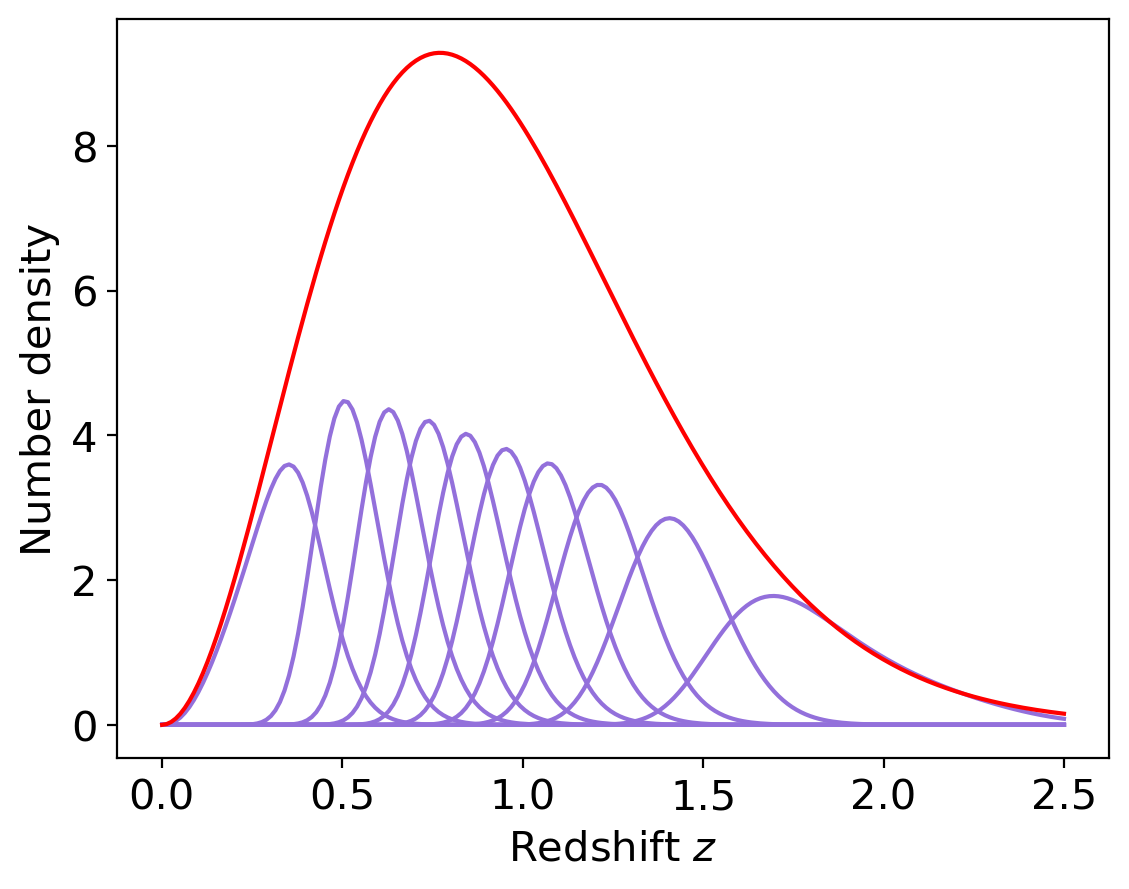

In [104]:
fig, ax = plt.subplots()

for i in range(10):
    ax.plot(z_to_plot, dict_ndsty['bin_ndensity_%s'%(str(i))](z_to_plot), c='mediumpurple')
ax.plot(z_to_plot, 24*n(z_to_plot), c='red')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('Number density');

In [105]:
def window(i, z, zmax=2.5, cosparam=dict_fiducial):
    """Reduced window function as a function of redshift.
    trapz from numpy is used for integration.
    ===================================================
    Inputs: bin number i, redshift z, min/max redshift 
    zmin/zmax (optional, default=0.001/2.5)
    Output: window function evaluated at z, of the ith bin.
    """
    def integrand(w):
        return dict_ndsty['bin_ndensity_%s' % (str(i))](w) * (1 - r(z, cosparam) / r(w, cosparam))
    
    z_int = np.linspace(z, zmax, 200)
    integral = np.trapz(integrand(z_int), z_int)

    return integral


def weight(i, z, cosparam=dict_fiducial):
    """Weight function of the ith bin, as a function of
    redshift.
    ===================================================
    Inputs: bin number i, redshift z, matter density 
    Omega_m (optional, default provided by CAMB)
    Output: weight function evaluated at z, of the ith bin
    """
    H0 = cosparam['hubble'] * 100
    constant = 3 / 2 * (H0 / l_speed) ** 2 * cosparam['Omegam']
    z_dep = (1 + z) * r(z, cosparam) * window(i, z, cosparam=cosparam)
    return constant * z_dep

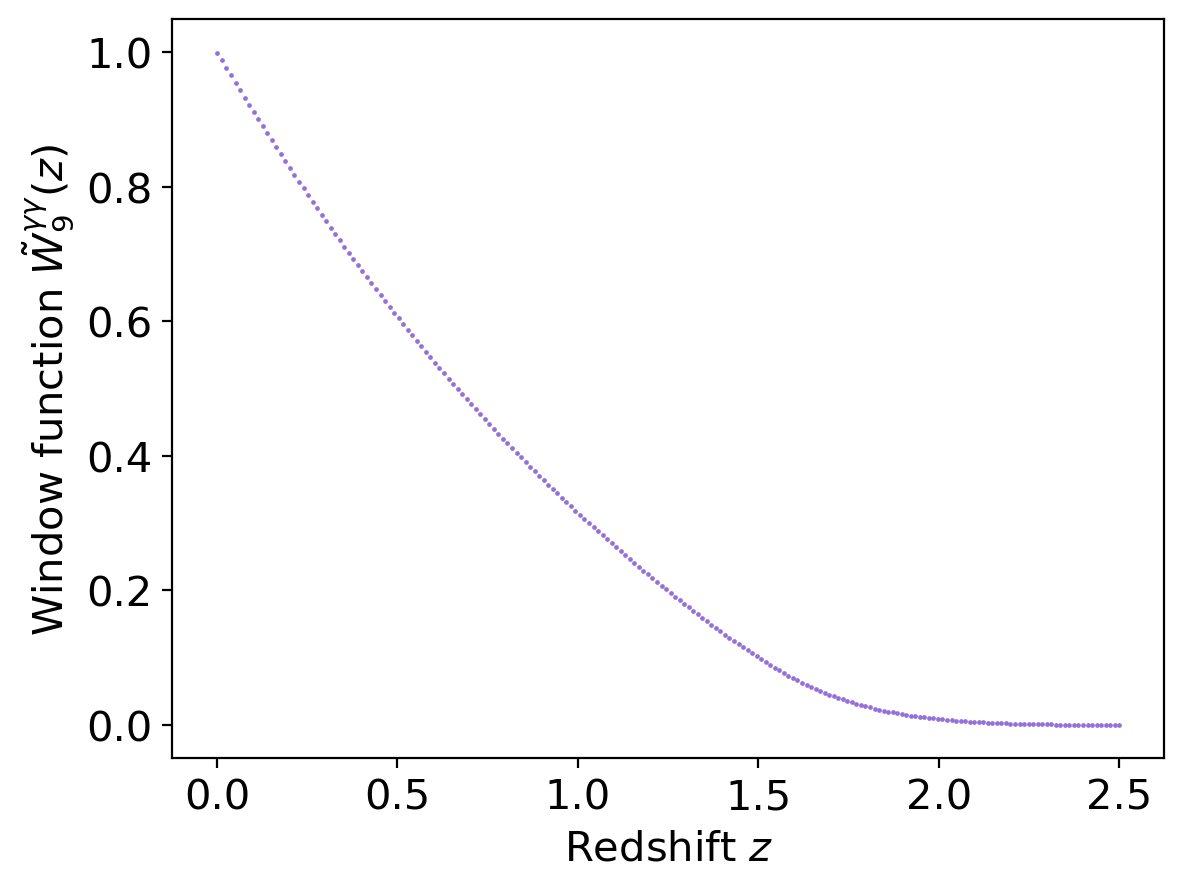

In [106]:
i = 9

fig, ax = plt.subplots()

for z in z_to_plot:
    ax.scatter(z, window(i, z), c='mediumpurple', s=0.5)
ax.set_xlabel('Redshift $z$')
ax.set_ylabel(r'Window function $\tilde{W}_%s^{\gamma\gamma}(z)$'%(str(i)));

### Cosmic shear

In [108]:
locals().update(dict_fiducial)

pars = model.CAMBparams()
pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='fluid')
pars.set_cosmology(H0=hubble*100, ombh2=Omegab*hubble**2, omch2=Omegac*hubble**2, tau=0.058)
pars.InitPower.set_params(As=2.1260500000000005e-9, ns=ns)

pars.set_matter_power(redshifts=np.linspace(0.001, 2.5, 101), kmax=50/hubble)
pars.NonLinearModel.set_params(halofit_version=4)
pars.set_accuracy(AccuracyBoost=2)
# Non linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=50, npoints=200)

dict_mps_data = {'kh': kh, 'z': z, 'pk':pk}

Note: redshifts have been re-sorted (earliest first)


In [109]:
# Interpolating the data
mps_fiducial = interpolate.RectBivariateSpline(z, kh, pk)

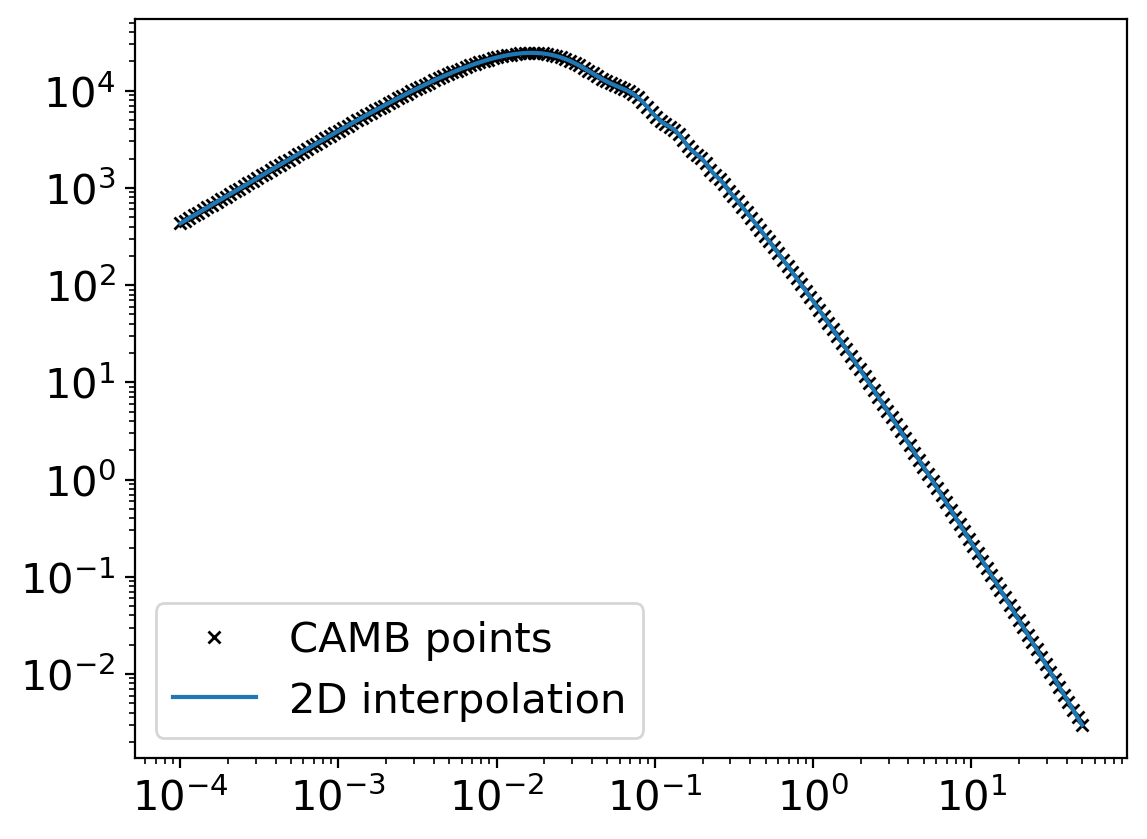

In [110]:
fig, ax = plt.subplots()

ax.plot(kh, pk[0,:], 'x', color='k', label='CAMB points', ms=4)
ax.plot(kh, mps_fiducial(0, kh)[0], label='2D interpolation')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend();

In [111]:
def convergence(i, j, l, fiducial=dict_fiducial, zmin=0.001, zmax=2.5):
    H0 = fiducial['hubble'] * 100
    def integrand(z):
        term1 = weight(i, z, fiducial) * weight(j, z, fiducial) / \
            (E(z, fiducial) * r(z, fiducial) ** 2)
        k = (l + 1/2) / r(z)
        term2 = mps_fiducial(z, k)[0]
        return term1 * term2
    integral = integrate.quad(integrand, zmin, zmax)[0]
    return l_speed / H0 * integral

#### Correct ells to evaluate

In [112]:
ls = np.logspace(1, np.log10(1500), 101)
l_bins = [(ls[i], ls[i + 1]) for i in range(100)]
ls_eval = np.array([(l_bins[i][1] + l_bins[i][0]) / 2 for i in range(100)])

In [ ]:
# # Getting the correct array
# cosmic_shear = np.zeros((len(ls_eval), 10, 10))
# 
# for idx, ell in enumerate(ls_eval):
#     for i in range(10):
#         for j in range(10):
#             cosmic_shear[idx, i, j] = convergence(i, j, ell)
#     print('index: %f'% (idx), end= '\r')

In [28]:
#reshape_cosmic = np.reshape(cosmic_shear, (cosmic_shear.shape[0], -1))
#np.savetxt('convergence/cosmic_shear_correctls', reshape_cosmic)

In [113]:
load_cosmic = np.loadtxt('convergence/cosmic_shear')
cosmic_shear = np.reshape(load_cosmic, (load_cosmic.shape[0], load_cosmic.shape[1] // 10, 10))

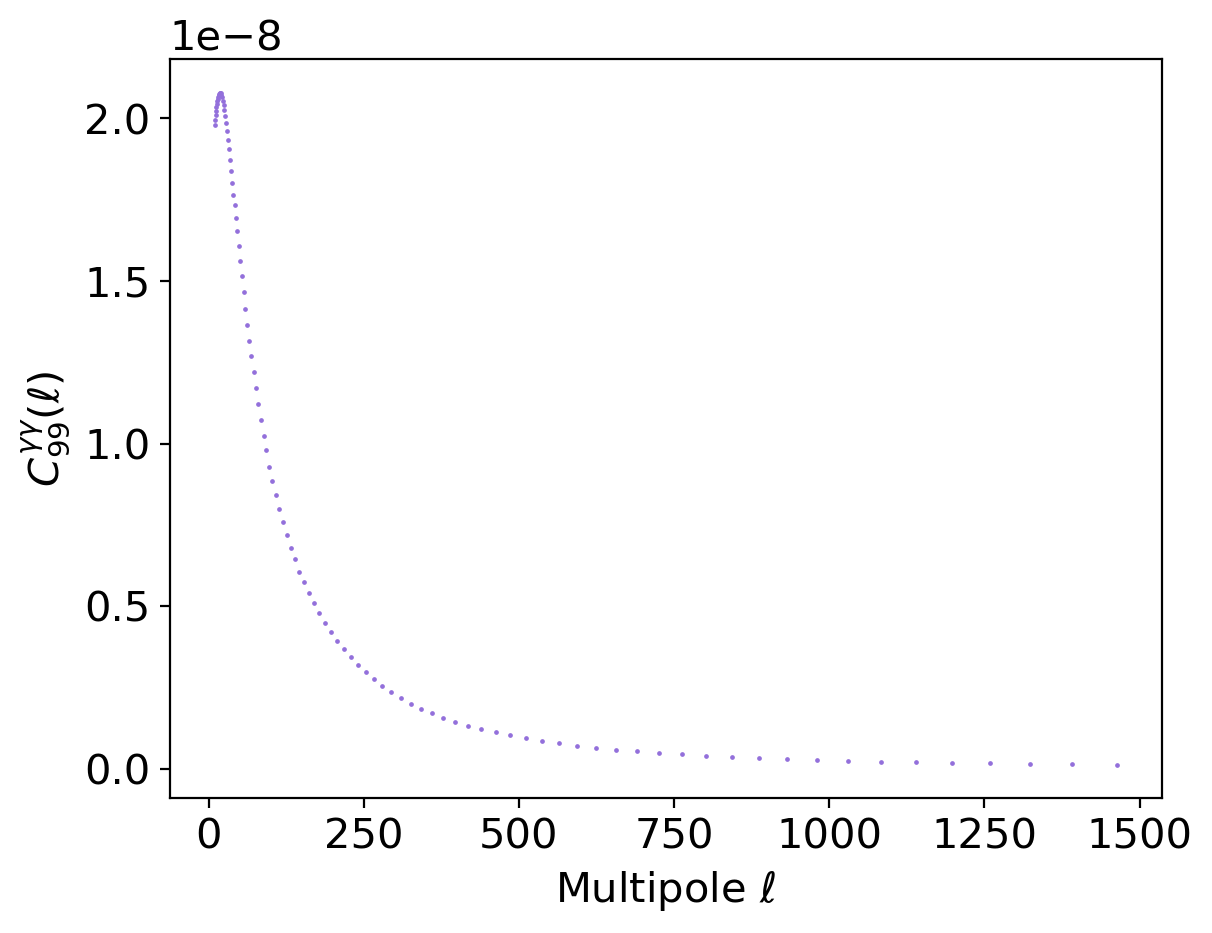

In [114]:
fig, ax = plt.subplots()

i, j = 9, 9

for idx, l in enumerate(ls_eval):
    ax.scatter(l, cosmic_shear[idx, i, j], c='mediumpurple', s=0.5)
ax.set_xlabel('Multipole $\ell$')
ax.set_ylabel(r'$C_{%s%s}^{\gamma\gamma}(\ell)$'%(str(i),str(j)));
#ax.legend()

## Fisher Matrix

### Components for building it

The error on the observed cosmic shear angular power spectrum can be expressed as $$\Delta C_{ij}^{\epsilon\epsilon}(\ell) = \sqrt{\frac{2}{(2l+1)\Delta \ell f_{sky}}}C_{ij}^{\epsilon\epsilon}(\ell)$$ where $f_{sky}$ is the fraction of surveyed sky, $\Delta \ell $ is the multipole bandwth and the last term is a Poisson noise term.

The covariance matrix is defined as $$Cov[C_{ij}^{\epsilon\epsilon}(\ell), C_{kl}^{\epsilon\epsilon}(\ell')]=\frac{C_{ik}^{\epsilon\epsilon} C_{jl}^{\epsilon\epsilon}(\ell') + C_{il}^{\epsilon\epsilon}(\ell)C_{lk}^{\epsilon\epsilon}(\ell')}{(2l+1)f_{sky}\Delta \ell}\delta_{ll'}^K$$

In the case that one assumes the signal is the covariance, the Fisher matrix reads
$$F_{\alpha\beta}=\sum_{\ell=\ell_{min}}^{\ell_{max}}\sum_{ij,mn}\frac{\partial C_{ij}^{\epsilon\epsilon}(\ell)}{\partial \theta_\alpha}\left\{[\Delta C^{\epsilon\epsilon}(\ell)]^{-1}\right\}_{jm}
\frac{\partial C_{mn}^{\epsilon\epsilon}(\ell)}{\partial \theta_\beta}\left\{[\Delta C^{\epsilon\epsilon}(\ell)]^{-1}\right\}_{ni}$$ No cross correlation between the modes with different $l_s$ is included, which is true under the Gaussian covariance assumption.

In the case that one assumes the signal is the mean power spectrum, the Fisher matrix reads
$$F_{\alpha\beta}=\sum_{\ell=\ell_{min}}^{\ell{max}}\sum_{ij,mn}\frac{\partial C_{ij}^{\epsilon\epsilon}(\ell)}{\partial \theta_\alpha}\text{Cov}^{-1}[C_{ij}^{\epsilon\epsilon}(\ell), C_{mn}^{\epsilon\epsilon}(\ell)]
\frac{\partial C_{mn}^{\epsilon\epsilon}(\ell)}{\partial \theta_\beta}$$ 

The derivative, can be computed as follows. Since the cosmic shear is the dominant observable, the others are negleclted, ie, $C_{ij}^{\epsilon\epsilon} \approx C_{ij}^{\gamma\gamma} + N_{ij}^\epsilon(\ell)$. Then, the derivated of interest is
$$\frac{\partial C_{ij}^{\gamma\gamma}(\ell)}{\partial \theta_\mu} = \int_{z_{min}}^{z_{max}}dz\frac{\partial K_{ij}^{\gamma\gamma}(z)}{\partial \theta_\mu} P_{\delta\delta}[k_\ell(z),z] +\int_{z_{min}}^{z_{max}}dzK_{ij}^{\gamma\gamma}(z)\frac{\partial P_{\delta\delta}[k_\ell(z),z]}{\partial \theta_\mu}$$ 

where 
$K_{ij}^{\gamma\gamma}(z) =  \left[\frac{3}{2}\Omega_{m,0}(1+z)\right]²\left(\frac{H_0}{c}\right)³\frac{\tilde{W}_i^\gamma(z)\tilde{W}_j^\gamma(z)}{E(z)}$

In [115]:
def error_convergence(l_idx, fsky=0.36361):
    dl = l_bins[idx][1] - l_bins[idx][0]
    term1 = np.sqrt(2 / ((2 * ls_eval[l_idx] + 1) * dl * fsky))
    term2 = cosmic_shear[l_idx]
    return term1 * term2 

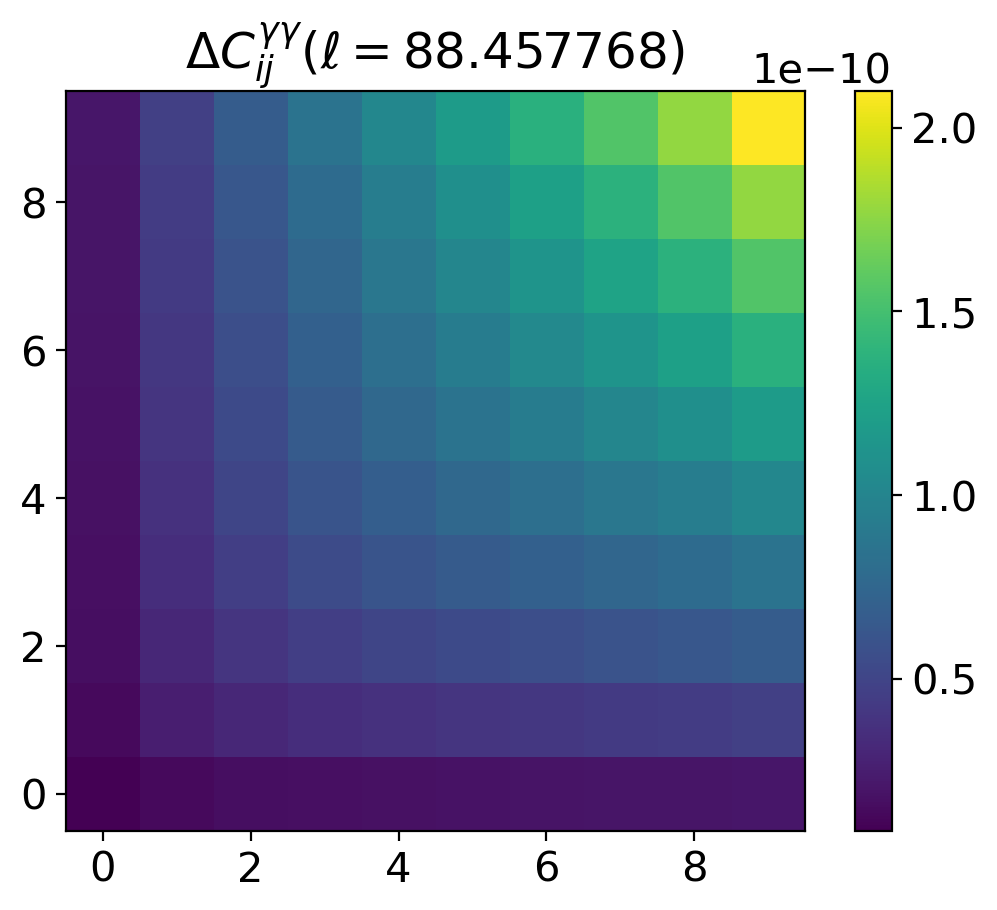

In [116]:
ell_idx = 43

fig, ax = plt.subplots()

im = ax.imshow(error_convergence(ell_idx))
ax.set_title('$\Delta C_{ij}^{\gamma\gamma}(\ell=%f)$'%ls_eval[ell_idx])
ax.set_ylim(ax.get_ylim()[::-1])
fig.colorbar(im)

In [118]:
def covariance(i, j, m, n, fsky=0.36361):
    covariance_matrix = np.zeros((100, 100))
    for idx in range(len(ls_eval)):
        dl = l_bins[idx][1] - l_bins[idx][0]
        num1 = cosmic_shear[idx, i, m] * cosmic_shear[idx, j, n]
        num2 = cosmic_shear[idx, i, n] * cosmic_shear[idx, j, m]
        covariance_matrix[idx, idx] = (num1 + num2) / ((2 * ls_eval[idx] + 1) * fsky * dl)
    return covariance_matrix

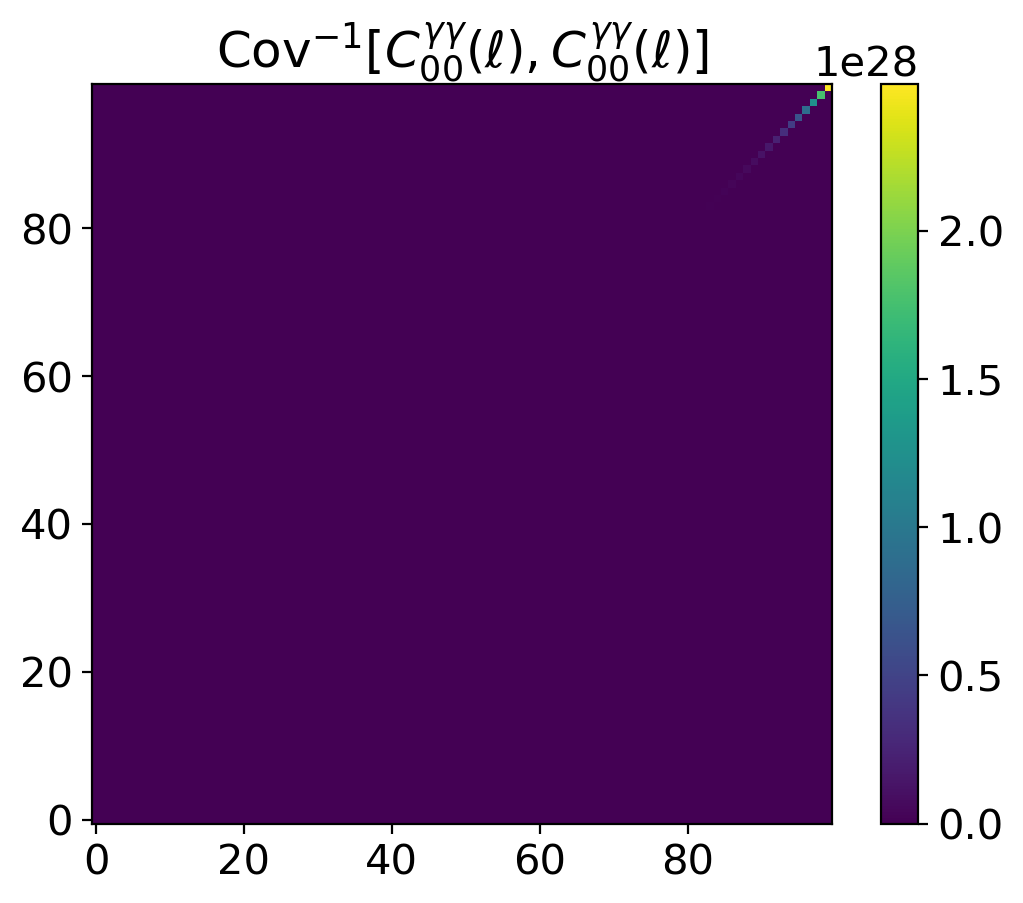

In [119]:
ell = ls_eval[0]
i, j = 0, 0
m, n = 0, 0
fig, ax = plt.subplots()

im = ax.imshow(np.linalg.inv(covariance(i, j, m, n)))
ax.set_title('Cov$^{-1}[C_{%i%i}^{\gamma\gamma}(\ell), C_{%i%i}^{\gamma\gamma}(\ell)]$'%(i,j,m,n))
ax.set_ylim(ax.get_ylim()[::-1])
fig.colorbar(im)

In [58]:
def mps_param(param, dx=0.01, fiducial=dict_fiducial):
    locals().update(fiducial)
    pars_l = camb.CAMBparams()
    pars_u = camb.CAMBparams()
    if param == 'Omegam':
        Omegab_l, Omegab_u = (1 - dx) * Omegab, (1 + dx) * Omegab
        Omegach2_l, Omegach2_u = (1 - dx) * Omegac *hubble**2, (1 + dx) * Omegac *hubble**2

        pars_l.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
        pars_u.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
        pars_l.set_cosmology(H0=hubble*100, ombh2=Omegab_l *
                             hubble**2, omch2=Omegach2_l, tau=0.058)
        pars_u.set_cosmology(H0=hubble*100, ombh2=Omegab_u *
                             hubble**2, omch2=Omegach2_u, tau=0.058)
        pars_l.InitPower.set_params(As=2.1260500000000005e-9, ns=ns)
        pars_u.InitPower.set_params(As=2.1260500000000005e-9, ns=ns)
        pars_l.set_matter_power(redshifts=np.linspace(0.001, 2.5, 101), kmax=50/hubble)
        pars_u.set_matter_power(redshifts=np.linspace(0.001, 2.5, 101), kmax=50/hubble)
        pars_l.NonLinearModel.set_params(halofit_version=4)
        pars_u.NonLinearModel.set_params(halofit_version=4)
        pars_l.set_accuracy(AccuracyBoost=2)
        pars_u.set_accuracy(AccuracyBoost=2)
        # Linear spectra
        pars_l.NonLinear = model.NonLinear_none
        pars_u.NonLinear = model.NonLinear_none
        results_l = camb.get_results(pars_l)
        results_u = camb.get_results(pars_u)
        kh_l, z_l, pk_l = results_l.get_matter_power_spectrum(
            minkh=1e-4, maxkh=50, npoints=200)
        kh_u, z_u, pk_u = results_u.get_matter_power_spectrum(
            minkh=1e-4, maxkh=50, npoints=200)

        # Store data for this model
        dict_mps_data = {'kh_l': kh_l, 'z_l': z_l, 'pk_l': pk_l,
                         'kh_u': kh_u, 'z_u': z_u, 'pk_u': pk_u}

        for rslt in dict_mps_data:
            np.savetxt('mps_data/Omegam_'+rslt, dict_mps_data[rslt])

    elif param == 'Omegab':
        Omegab_l, Omegab_u = (1 - dx) * Omegab, (1 + dx) * Omegab
        pars_l.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
        pars_u.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
        pars_l.set_cosmology(H0=hubble*100, ombh2=Omegab_l*hubble**2,
                             omch2=Omegac*hubble**2, tau=0.058)
        pars_u.set_cosmology(H0=hubble*100, ombh2=Omegab_u*hubble**2,
                             omch2=Omegac*hubble**2, tau=0.058)
        pars_l.InitPower.set_params(As=2.1260500000000005e-9, ns=ns)
        pars_u.InitPower.set_params(As=2.1260500000000005e-9, ns=ns)
        pars_l.set_matter_power(redshifts=np.linspace(0.001, 2.5, 101), kmax=50/hubble)
        pars_u.set_matter_power(redshifts=np.linspace(0.001, 2.5, 101), kmax=50/hubble)
        pars_l.NonLinearModel.set_params(halofit_version=4)
        pars_u.NonLinearModel.set_params(halofit_version=4)
        pars_l.set_accuracy(AccuracyBoost=2)
        pars_u.set_accuracy(AccuracyBoost=2)
        # Linear spectra
        pars_l.NonLinear = model.NonLinear_none
        pars_u.NonLinear = model.NonLinear_none
        results_l = camb.get_results(pars_l)
        results_u = camb.get_results(pars_u)
        kh_l, z_l, pk_l = results_l.get_matter_power_spectrum(
            minkh=1e-4, maxkh=50, npoints=200)
        kh_u, z_u, pk_u = results_u.get_matter_power_spectrum(
            minkh=1e-4, maxkh=50, npoints=200)

        # Store data for this model
        dict_mps_data = {'kh_l': kh_l, 'z_l': z_l, 'pk_l': pk_l,
                         'kh_u': kh_u, 'z_u': z_u, 'pk_u': pk_u}

        for rslt in dict_mps_data:
            np.savetxt('mps_data/Omegab_'+rslt, dict_mps_data[rslt])

    elif param == 'ns':
        ns_l, ns_u = (1 - dx) * ns, (1 + dx) * ns

        pars_l.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
        pars_u.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
        pars_l.set_cosmology(H0=hubble*100, ombh2=Omegab *
                             hubble**2, omch2=Omegac*hubble**2, tau=0.058)
        pars_u.set_cosmology(H0=hubble*100, ombh2=Omegab *
                             hubble**2, omch2=Omegac*hubble**2, tau=0.058)
        pars_l.InitPower.set_params(As=2.1260500000000005e-9, ns=ns_l)
        pars_u.InitPower.set_params(As=2.1260500000000005e-9, ns=ns_u)
        pars_l.set_matter_power(redshifts=np.linspace(0.001, 2.5, 101), kmax=50/hubble)
        pars_u.set_matter_power(redshifts=np.linspace(0.001, 2.5, 101), kmax=50/hubble)
        pars_l.NonLinearModel.set_params(halofit_version=4)
        pars_u.NonLinearModel.set_params(halofit_version=4)
        pars_l.set_accuracy(AccuracyBoost=2)
        pars_u.set_accuracy(AccuracyBoost=2)
        # Linear spectra
        pars_l.NonLinear = model.NonLinear_none
        pars_u.NonLinear = model.NonLinear_none
        results_l = camb.get_results(pars_l)
        results_u = camb.get_results(pars_u)
        kh_l, z_l, pk_l = results_l.get_matter_power_spectrum(
            minkh=1e-4, maxkh=50, npoints=200)
        kh_u, z_u, pk_u = results_u.get_matter_power_spectrum(
            minkh=1e-4, maxkh=50, npoints=200)

        # Store data for this model
        dict_mps_data = {'kh_l': kh_l, 'z_l': z_l, 'pk_l': pk_l,
                         'kh_u': kh_u, 'z_u': z_u, 'pk_u': pk_u}

        for rslt in dict_mps_data:
            np.savetxt('mps_data/ns_'+rslt, dict_mps_data[rslt])

    elif param == 'hubble':
        hubble_l, hubble_u = (1 - dx) * hubble, (1 + dx) * hubble

        pars_l.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
        pars_u.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
        pars_l.set_cosmology(H0=hubble_l*100, ombh2=Omegab *
                             hubble_l**2, omch2=Omegac*hubble_l**2, tau=0.058)
        pars_u.set_cosmology(H0=hubble_u*100, ombh2=Omegab *
                             hubble_u**2, omch2=Omegac*hubble_u**2, tau=0.058)
        pars_l.InitPower.set_params(As=2.1260500000000005e-9, ns=ns)
        pars_u.InitPower.set_params(As=2.1260500000000005e-9, ns=ns)
        pars_l.set_matter_power(redshifts=np.linspace(0.001, 2.5, 101), kmax=50/hubble_l)
        pars_u.set_matter_power(redshifts=np.linspace(0.001, 2.5, 101), kmax=50/hubble_u)
        pars_l.NonLinearModel.set_params(halofit_version=4)
        pars_u.NonLinearModel.set_params(halofit_version=4)
        pars_l.set_accuracy(AccuracyBoost=2)
        pars_u.set_accuracy(AccuracyBoost=2)
        # Linear spectra
        pars_l.NonLinear = model.NonLinear_none
        pars_u.NonLinear = model.NonLinear_none
        results_l = camb.get_results(pars_l)
        results_u = camb.get_results(pars_u)
        kh_l, z_l, pk_l = results_l.get_matter_power_spectrum(
            minkh=1e-4, maxkh=50, npoints=200)
        kh_u, z_u, pk_u = results_u.get_matter_power_spectrum(
            minkh=1e-4, maxkh=50, npoints=200)

        # Store data for this model
        dict_mps_data = {'kh_l': kh_l, 'z_l': z_l, 'pk_l': pk_l,
                         'kh_u': kh_u, 'z_u': z_u, 'pk_u': pk_u}

        for rslt in dict_mps_data:
            np.savetxt('mps_data/hubble_'+rslt, dict_mps_data[rslt])

    elif param == 'sigma8':
        p = 0.9999164512725376
        As = 2.1260500000000005e-9
        As_l, As_u = As / (p + dx), As / (p - dx)

        pars_l.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
        pars_u.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
        pars_l.set_cosmology(H0=hubble*100, ombh2=Omegab *
                             hubble**2, omch2=Omegac*hubble**2, tau=0.058)
        pars_u.set_cosmology(H0=hubble*100, ombh2=Omegab *
                             hubble**2, omch2=Omegac*hubble**2, tau=0.058)
        pars_l.InitPower.set_params(As=As_l, ns=ns)
        pars_u.InitPower.set_params(As=As_u, ns=ns)
        pars_l.set_matter_power(redshifts=np.linspace(0.001, 2.5, 101), kmax=50/hubble)
        pars_u.set_matter_power(redshifts=np.linspace(0.001, 2.5, 101), kmax=50/hubble)
        pars_l.NonLinearModel.set_params(halofit_version=4)
        pars_u.NonLinearModel.set_params(halofit_version=4)
        pars_l.set_accuracy(AccuracyBoost=2)
        pars_u.set_accuracy(AccuracyBoost=2)
        # Linear spectra
        pars_l.NonLinear = model.NonLinear_none
        pars_u.NonLinear = model.NonLinear_none
        results_l = camb.get_results(pars_l)
        results_u = camb.get_results(pars_u)
        kh_l, z_l, pk_l = results_l.get_matter_power_spectrum(
            minkh=1e-4, maxkh=50, npoints=200)
        kh_u, z_u, pk_u = results_u.get_matter_power_spectrum(
            minkh=1e-4, maxkh=50, npoints=200)

        # Store data for this model
        dict_mps_data = {'kh_l': kh_l, 'z_l': z_l, 'pk_l': pk_l,
                         'kh_u': kh_u, 'z_u': z_u, 'pk_u': pk_u}

        for rslt in dict_mps_data:
            np.savetxt('mps_data/ns_'+rslt, dict_mps_data[rslt])

In [59]:
mps_param('Omegam', fiducial=dict_fiducial)
mps_param('Omegab', fiducial=dict_fiducial)
mps_param('ns', fiducial=dict_fiducial)
mps_param('hubble', fiducial=dict_fiducial)
mps_param('sigma8', fiducial=dict_fiducial)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


In [120]:
# Loading data from matter power spectrum
dict_mps_omegam = {'kh_l': None, 'kh_u': None, 'z_l': None, 'z_u': None, 'pk_l': None, 'pk_u': None}
dict_mps_omegab = {'kh_l': None, 'kh_u': None, 'z_l': None, 'z_u': None, 'pk_l': None, 'pk_u': None}
dict_mps_ns = {'kh_l': None, 'kh_u': None, 'z_l': None, 'z_u': None, 'pk_l': None, 'pk_u': None}
dict_mps_h = {'kh_l': None, 'kh_u': None, 'z_l': None, 'z_u': None, 'pk_l': None, 'pk_u': None}
dict_mps_s8 = {'kh_l': None, 'kh_u': None, 'z_l': None, 'z_u': None, 'pk_l': None, 'pk_u': None} 
for rslt in dict_mps_h:
    dict_mps_omegam[rslt] = np.loadtxt('mps_data/Omegam_'+rslt)
    dict_mps_omegab[rslt] = np.loadtxt('mps_data/Omegab_'+rslt)
    dict_mps_ns[rslt] = np.loadtxt('mps_data/ns_'+rslt)
    dict_mps_h[rslt] = np.loadtxt('mps_data/hubble_'+rslt)
    dict_mps_s8[rslt] = np.loadtxt('mps_data/sigma8_'+rslt)

In [121]:
# Interpolating the data
mps_Omegam_l = interpolate.RectBivariateSpline(dict_mps_omegam['z_l'], dict_mps_omegam['kh_l'], dict_mps_omegam['pk_l'])
mps_Omegam_u = interpolate.RectBivariateSpline(dict_mps_omegam['z_u'], dict_mps_omegam['kh_u'], dict_mps_omegam['pk_u'])

mps_Omegab_l = interpolate.RectBivariateSpline(dict_mps_omegab['z_l'], dict_mps_omegab['kh_l'], dict_mps_omegab['pk_l'])
mps_Omegab_u = interpolate.RectBivariateSpline(dict_mps_omegab['z_u'], dict_mps_omegab['kh_u'], dict_mps_omegab['pk_u'])

mps_ns_l = interpolate.RectBivariateSpline(dict_mps_ns['z_l'], dict_mps_ns['kh_l'], dict_mps_ns['pk_l'])
mps_ns_u = interpolate.RectBivariateSpline(dict_mps_ns['z_u'], dict_mps_ns['kh_u'], dict_mps_ns['pk_u'])

mps_hubble_l = interpolate.RectBivariateSpline(dict_mps_h['z_l'], dict_mps_h['kh_l'], dict_mps_h['pk_l'])
mps_hubble_u = interpolate.RectBivariateSpline(dict_mps_h['z_u'], dict_mps_h['kh_u'], dict_mps_h['pk_u'])

mps_sigma8_l = interpolate.RectBivariateSpline(dict_mps_s8['z_l'], dict_mps_s8['kh_l'], dict_mps_s8['pk_l'])
mps_sigma8_u = interpolate.RectBivariateSpline(dict_mps_s8['z_u'], dict_mps_s8['kh_u'], dict_mps_s8['pk_u'])

In [122]:
dict_mps_interpolation = {'mps_Omegam_l': mps_Omegam_l, 'mps_Omegam_u': mps_Omegam_u, 
                          'mps_Omegab_l': mps_Omegab_l, 'mps_Omegab_u': mps_Omegab_u,
                          'mps_ns_l': mps_ns_l, 'mps_ns_u': mps_ns_u,
                          'mps_hubble_l': mps_hubble_l, 'mps_hubble_u': mps_hubble_u,
                          'mps_sigma8_l': mps_sigma8_l, 'mps_sigma8_u': mps_sigma8_u}

In [123]:
# Redefine convergence

def convergence_param(i, j, l, param, dx=0.01, cosmpar=dict_fiducial, zmin=0.001, zmax=2.5):
    dict_low, dict_up = cosmpar.copy(), cosmpar.copy()
    dict_low[param] = (1 - dx) * dict_low[param]
    dict_up[param] = (1 + dx) * dict_up[param]
    H0_l = dict_low['hubble'] * 100
    H0_u = dict_up['hubble'] * 100
    def integrand(z, dict=None , var=''):
        term1 = weight(i, z, dict) * weight(j, z, dict) / \
            (E(z, dict) * r(z, dict) ** 2)
        k = (l + 1/2) / r(z, dict)
        term2 = dict_mps_interpolation['mps_'+param+var](z, k)[0]
        return term1 * term2
    integral_l = integrate.quad(integrand, zmin, zmax, (dict_low, '_l'))[0]
    integral_u = integrate.quad(integrand, zmin, zmax, (dict_up, '_u'))[0]
    return [l_speed / H0_l * integral_l, l_speed / H0_u * integral_u]

#### $\Omega_{m,0}$

In [ ]:
# # For Omega_m
# cosmic_shear_Omegam = np.zeros((len(ls_eval), 10, 10))
# dx=0.01
# 
# for idx, ell in enumerate(ls_eval):
#     for i in range(10):
#         for j in range(10):
#             aux = convergence_param(i, j, ell, 'Omegam', dx=dx)
#             cosmic_shear_Omegam[idx, i, j] = (aux[1] - aux[0]) / (2 * dx)
#             print('ell: %f'% (ell), end= '\r')

In [103]:
# reshape_cosmic = np.reshape(cosmic_shear_Omegam, (cosmic_shear_Omegam.shape[0], -1))
# np.savetxt('convergence/cosmic_shear_omegam', reshape_cosmic)

In [124]:
load_cosmic = np.loadtxt('convergence/cosmic_shear_omegam')
cosmic_shear_Omegam = np.reshape(load_cosmic, (load_cosmic.shape[0], load_cosmic.shape[1] // 10, 10))

#### $\Omega_{b, 0}$

In [ ]:
# # For Omega_b
# cosmic_shear_Omegab = np.zeros((len(ls_eval), 10, 10))
# dx=0.01
# 
# for idx, ell in enumerate(ls_eval):
#     for i in range(10):
#         for j in range(10):
#             aux = convergence_param(i, j, ell, 'Omegab', dx=dx)
#             cosmic_shear_Omegab[idx, i, j] = (aux[1] - aux[0]) / (2 * dx)
#     print('index: %i'% (idx), end= '\r')

In [76]:
# reshape_cosmic = np.reshape(cosmic_shear_Omegab, (cosmic_shear_Omegab.shape[0], -1))
# np.savetxt('convergence/cosmic_shear_omegab', reshape_cosmic)

In [139]:
load_cosmic = np.loadtxt('convergence/cosmic_shear_omegab')
cosmic_shear_Omegab = np.reshape(load_cosmic, (load_cosmic.shape[0], load_cosmic.shape[1] // 10, 10))

#### $h$

In [53]:
# # For hubble
# cosmic_shear_hubble = np.zeros((len(ls_eval), 10, 10))
# dx=0.01
# 
# for idx, ell in enumerate(ls_eval):
#     for i in range(10):
#         for j in range(10):
#             aux = convergence_param(i, j, ell, 'hubble', dx=dx)
#             cosmic_shear_hubble[idx, i, j] = (aux[1] - aux[0]) / (2 * dx)
#             print('index: %f'% (idx), end= '\r')

In [54]:
# reshape_cosmic = np.reshape(cosmic_shear_hubble, (cosmic_shear_hubble.shape[0], -1))
# np.savetxt('convergence/cosmic_shear_hubble', reshape_cosmic)

In [126]:
load_cosmic = np.loadtxt('convergence/cosmic_shear_hubble')
cosmic_shear_hubble = np.reshape(load_cosmic, (load_cosmic.shape[0], load_cosmic.shape[1] // 10, 10))

#### $n_s$

In [42]:
# # For ns
# cosmic_shear_ns = np.zeros((len(ls_eval), 10, 10))
# dx=0.01
# 
# for idx, ell in enumerate(ls_eval):
#     for i in range(10):
#         for j in range(10):
#             aux = convergence_param(i, j, ell, 'ns', dx=dx)
#             cosmic_shear_ns[idx, i, j] = (aux[1] - aux[0]) / (2 * dx)
#             print('index: %f'% (idx), end= '\r')

In [43]:
# reshape_cosmic = np.reshape(cosmic_shear_ns, (cosmic_shear_ns.shape[0], -1))
# np.savetxt('convergence/cosmic_shear_ns', reshape_cosmic)

In [127]:
load_cosmic = np.loadtxt('convergence/cosmic_shear_ns')
cosmic_shear_ns = np.reshape(load_cosmic, (load_cosmic.shape[0], load_cosmic.shape[1] // 10, 10))

#### $\sigma_8$

In [84]:
# # For ns
# cosmic_shear_sigma8 = np.zeros((len(ls_eval), 10, 10))
# dx=0.01
# 
# for idx, ell in enumerate(ls_eval):
#     for i in range(10):
#         for j in range(10):
#             aux = convergence_param(i, j, ell, 'sigma8', dx=dx)
#             cosmic_shear_sigma8[idx, i, j] = (aux[1] - aux[0]) / (2 * dx)
#     print('index: %i'% (idx), end= '\r')

In [85]:
# reshape_cosmic = np.reshape(cosmic_shear_sigma8, (cosmic_shear_sigma8.shape[0], -1))
# np.savetxt('convergence/cosmic_shear_sigma8', reshape_cosmic)

In [128]:
load_cosmic = np.loadtxt('convergence/cosmic_shear_sigma8')
cosmic_shear_sigma8 = np.reshape(load_cosmic, (load_cosmic.shape[0], load_cosmic.shape[1] // 10, 10))

#### Dictionary with cosmic shear data

In [140]:
dict_d_cosmic_shear = {'Omegam': cosmic_shear_Omegam, 'Omegab': cosmic_shear_Omegab,
                        'hubble': cosmic_shear_hubble, 'ns': cosmic_shear_ns, 'sigma8': cosmic_shear_sigma8}
                        #'w0': cosmic_shear_w0, 'wa': cosmic_shear_wa}

### Shot noise addition

In [141]:
def shot_noise(sigma_e=0.3, ng=30):
    ng_new = ng * (180 * 60 / np.pi) ** 2
    return sigma_e ** 2 / ng_new

In [142]:
for i in range(10):
    cosmic_shear[:, i, i] += shot_noise()

### Building the matrix

The idea is to build the matrix, such that whe get something like

$$\begin{array}{cc} &
\begin{array}{ccccccc} \Omega_{m,0} & \Omega_{b,0} & h & w_0 & w_a & n_s & \sigma_8
\end{array}
\\
\\
\begin{array}{ccccccc}
\Omega_{m,0} \\
\Omega_{b,0} \\
h \\
w_0 \\
w_a \\
n_s \\
\sigma_8
\end{array}
&
\left(
\begin{array}{ccccccc}
1 & 1 & 1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1 & 1 & 1
\end{array}
\right)
\end{array}$$

In [175]:
FisherMatrix = np.zeros((5, 5))

def fisher_matrix_component(alpha, beta):
    component = 0
    for i in range(10):
        for j in range(10):
            for m in range(10):
                for n in range(10):
                    cov_inv = np.linalg.inv(covariance(i, j, m, n))
                    cosmic_shear_alpha = dict_d_cosmic_shear[alpha][:,i,j]
                    cosmic_shear_beta = dict_d_cosmic_shear[beta][:,m,n]
                    component += np.matmul(cosmic_shear_alpha, np.matmul(cov_inv, cosmic_shear_beta))
    return component

In [176]:
for idx, param in enumerate(dict_d_cosmic_shear.keys()):
    FisherMatrix[idx,0] = fisher_matrix_component(param, 'Omegam')
    FisherMatrix[idx,1] = fisher_matrix_component(param, 'Omegab')
    FisherMatrix[idx,2] = fisher_matrix_component(param, 'hubble')
    FisherMatrix[idx,3] = fisher_matrix_component(param, 'ns')
    FisherMatrix[idx,4] = fisher_matrix_component(param, 'sigma8')
    

In [177]:
FisherMatrix

array([[ 3.24740201e+12, -3.84937791e+10,  3.29923740e+11,
         2.07117978e+11,  2.60933302e+11],
       [-3.84937791e+10,  6.01613815e+08, -5.20814526e+09,
        -2.96606986e+09, -4.01744006e+09],
       [ 3.29923740e+11, -5.20814526e+09,  4.51258362e+10,
         2.55379265e+10,  3.47459379e+10],
       [ 2.07117978e+11, -2.96606986e+09,  2.55379265e+10,
         1.51062566e+10,  1.99122788e+10],
       [ 2.60933302e+11, -4.01744006e+09,  3.47459379e+10,
         1.99122788e+10,  2.68511596e+10]])

In [178]:
np.linalg.inv(FisherMatrix).diagonal()

array([ 1.94604562e-12,  4.70687346e-06, -2.38737594e-08,  7.75516130e-08,
        8.89821109e-07])

## Plot

## Ellipses

In [71]:
from matplotlib.patches import Ellipse

In [72]:
colors = ['red', 'blue']#['lightcoral','darkturquoise']
cosmpar = [omegabh2ref, href, omegamh2ref, nsref, 0, 1]
parin = ['wb','h', 'wm', 'ns','a','fz']

def confidence_plot_tworesults(inde, par0, par1, ax, uncer_lvl=1):
    # inde could be 0 or 1
    center0 = cosmpar[inde][par0]
    center1 = cosmpar[inde][par1]
    alpha = [0, 0.8, 0.4]
    label1 = parin[par0]
    label2 = parin[par1]
    sigmax = np.sqrt(np.linalg.inv(FisherMatrix)[inde][par0,par0])
    sigmay = np.sqrt(np.linalg.inv(FisherMatrix)[inde][par1,par1])
    sigmaxy = np.linalg.inv(FisherMatrix)[inde][par1,par0]
    a, b, theta = ellipse_params(sigmax, sigmay, sigmaxy)
    if np.linalg.inv(FisherMatrix)[inde][par0,par0]<np.linalg.inv(FisherMatrix)[inde][par1,par1]:
        width=2.*b
        height=2.*a
    else:
        width=2.*a
        height=2.*b
    ellipse1 = Ellipse((center0, center1),
        width=width*CL_alpha[uncer_lvl],
        height=height*CL_alpha[uncer_lvl],
        angle=theta,linewidth=1., fill=False,zorder=2, edgecolor=colors[inde]) #fill_True,  alpha=alpha[uncer_lvl]
    return [ax.add_patch(ellipse1), center0, sigmax, center1, sigmay]


def ellipse_params(sigmax, sigmay, sigmaxy):
    term1 = (sigmax**2 + sigmay**2)/2.
    term2 = np.sqrt(0.25*(sigmax**2 - sigmay**2)**2 + sigmaxy**2)
    tan2theta = 2*sigmaxy/((sigmax**2 - sigmay**2))
    theta = (180./np.pi)*0.5*np.arctan(tan2theta)
    return np.sqrt(term1+term2), np.sqrt(term1-term2), theta

NameError: name 'omegabh2ref' is not defined

In [ ]:
lista = range(4)
parin2 = [r'$\Omega_{b}h^2$','h', r'$\Omega_{m}h^2$', r'$n_s$', r'$\mathcal{A}$', r'$f_\zeta$']
fig, axs = plt.subplots(2,2, figsize=(13, 10), facecolor='w', edgecolor='k')
num = 0
num2 = 0
for i in lista:
    par0=4
    par1 = i
    label1 = parin2[par0]
    label2 = parin2[par1]
    if par1==0 or par1==1:
        toplot, center01, sigmax1, center1, sigmay = confidence_plot_tworesults(0,par0, par1, axs[0, num2],uncer_lvl=1 )
        toplot2, center0, sigmax, center1, sigmay = confidence_plot_tworesults(0,par0, par1, axs[0, num2],uncer_lvl=2 )
        toplot3, center0, sigmax, center1, sigmay = confidence_plot_tworesults(1,par0, par1, axs[0, num2],uncer_lvl=1 )
        toplot4, center0, sigmax, center1, sigmay = confidence_plot_tworesults(1,par0, par1, axs[0, num2],uncer_lvl=2 )
        toplot
        toplot2
        toplot3
        toplot4
        axs[0, num2].set_xlim(center0-sigmax*4,center0+sigmax*4)
        axs[0, num2].set_ylim(center1-sigmay*4,center1+sigmay*4)
        axs[0, num2].set_xlabel(label1, fontsize=18)
        axs[0, num2].set_ylabel(label2, fontsize=18)
        num2+=1
    elif par1==2 or par1==3:
        toplot, center0, sigmax, center1, sigmay = confidence_plot_tworesults(0,par0, par1, axs[1, num],uncer_lvl=1 )
        toplot2, center0, sigmax, center1, sigmay = confidence_plot_tworesults(0,par0, par1, axs[1, num],uncer_lvl=2 )
        toplot3, center0, sigmax, center1, sigmay = confidence_plot_tworesults(1,par0, par1, axs[1, num],uncer_lvl=1 )
        toplot4, center0, sigmax, center1, sigmay = confidence_plot_tworesults(1,par0, par1, axs[1, num],uncer_lvl=2 )
        toplot
        toplot2
        toplot3
        toplot4
        axs[1, num].set_xlim(center0-sigmax*4,center0+sigmax*4)
        axs[1, num].set_ylim(center1-sigmay*4,center1+sigmay*4)
        axs[1, num].set_xlabel(label1, fontsize=18)
        axs[1, num].set_ylabel(label2, fontsize=18)
        num+=1
lista = range(4)
fig, axs = plt.subplots(2,2, figsize=(12, 10), facecolor='w', edgecolor='k')
num = 0
num2 = 0
for i in lista:
    par0=5
    par1 = i
    label1 = parin[par0]
    label2 = parin[par1]
    if par1==0 or par1==1:
        toplot, center01, sigmax1, center1, sigmay =confidence_plot_tworesults(0,par0, par1, axs[0, num2],uncer_lvl=1 )
        toplot2, center0, sigmax, center1, sigmay = confidence_plot_tworesults(0,par0, par1, axs[0, num2],uncer_lvl=2 )
        toplot3, center0, sigmax, center1, sigmay = confidence_plot_tworesults(1,par0, par1, axs[0, num2],uncer_lvl=1 )
        toplot4, center0, sigmax, center1, sigmay = confidence_plot_tworesults(1,par0, par1, axs[0, num2],uncer_lvl=2 )
        toplot
        toplot2
        toplot3
        toplot4
        axs[0, num2].set_xlim(center01-sigmax1*4,center01+sigmax1*4)
        axs[0, num2].set_ylim(center1-sigmay*4,center1+sigmay*4)
        axs[0, num2].set_xlabel(label1, fontsize=14)
        axs[0, num2].set_ylabel(label2, fontsize=14)
        num2+=1
    elif par1==2 or par1==3:
        toplot, center0, sigmax, center1, sigmay =confidence_plot_tworesults(0,par0, par1, axs[1, num],uncer_lvl=1 )
        toplot2, center0, sigmax, center1, sigmay = confidence_plot_tworesults(0,par0, par1, axs[1, num],uncer_lvl=2 )
        toplot3, center0, sigmax, center1, sigmay = confidence_plot_tworesults(1,par0, par1, axs[1, num],uncer_lvl=1 )
        toplot4, center0, sigmax, center1, sigmay = confidence_plot_tworesults(1,par0, par1, axs[1, num],uncer_lvl=2 )
        toplot
        toplot2
        toplot3
        toplot4
        axs[1, num].set_xlim(center0-sigmax*4,center0+sigmax*4)
        axs[1, num].set_ylim(center1-sigmay*4,center1+sigmay*4)
        axs[1, num].set_xlabel(label1, fontsize=14)
        axs[1, num].set_ylabel(label2, fontsize=14)
        num+=1